In [1]:
%matplotlib inline  
import random
import json
import math
import time

import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
import random
import numpy as np

from mymodel import MobileNet
from mynyudata import NyuDataset
import myutils
from ops import ConvBn, ConvDw, UpConv, PointWise, UpProj, MyBlock, DeConvDw, NNConvDw, ShuffleConvDw
import torch.nn as nn
import h5py

import transforms
import numpy as np

import matplotlib.pyplot as plt
from notebook import MyNet
from mynyudata import h5_loader, getnames

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyNet().to(DEVICE)
model.load_state_dict(torch.load('{}/fyn_model.pt'.format('.'), map_location=torch.device('cpu')))

<All keys matched successfully>

In [45]:
location = "/home/dlkhagvazhav/data/nyudepthv2/train/"
filenames = getnames(location)
random.shuffle(filenames)
size_set = 40
valset = NyuDataset(filenames[:size_set], train=False)
valloader = DataLoader(valset, batch_size=5, shuffle=True)

In [46]:
images, depths = iter(valloader).next()
predicted_depths = model(images)

In [34]:
len(images)

5

In [14]:
def show_results(images, depths, predicted_depths):
    columns = 3
    rows = len(depths)
    fig = plt.figure(figsize=(20, 20))
    p = 1
    for i in range(rows):
        fig.add_subplot(rows, columns, p)
        plt.imshow(images[i].detach().numpy().transpose((1, 2, 0)))
        fig.add_subplot(rows, columns, p+1)
        plt.imshow(depths[i].detach().numpy().reshape(depths[i].shape[1], -1))
        fig.add_subplot(rows, columns, p+2)
        plt.imshow(predicted_depths[i].detach().numpy().reshape(predicted_depths[i].shape[1], -1))
        p = p + 3

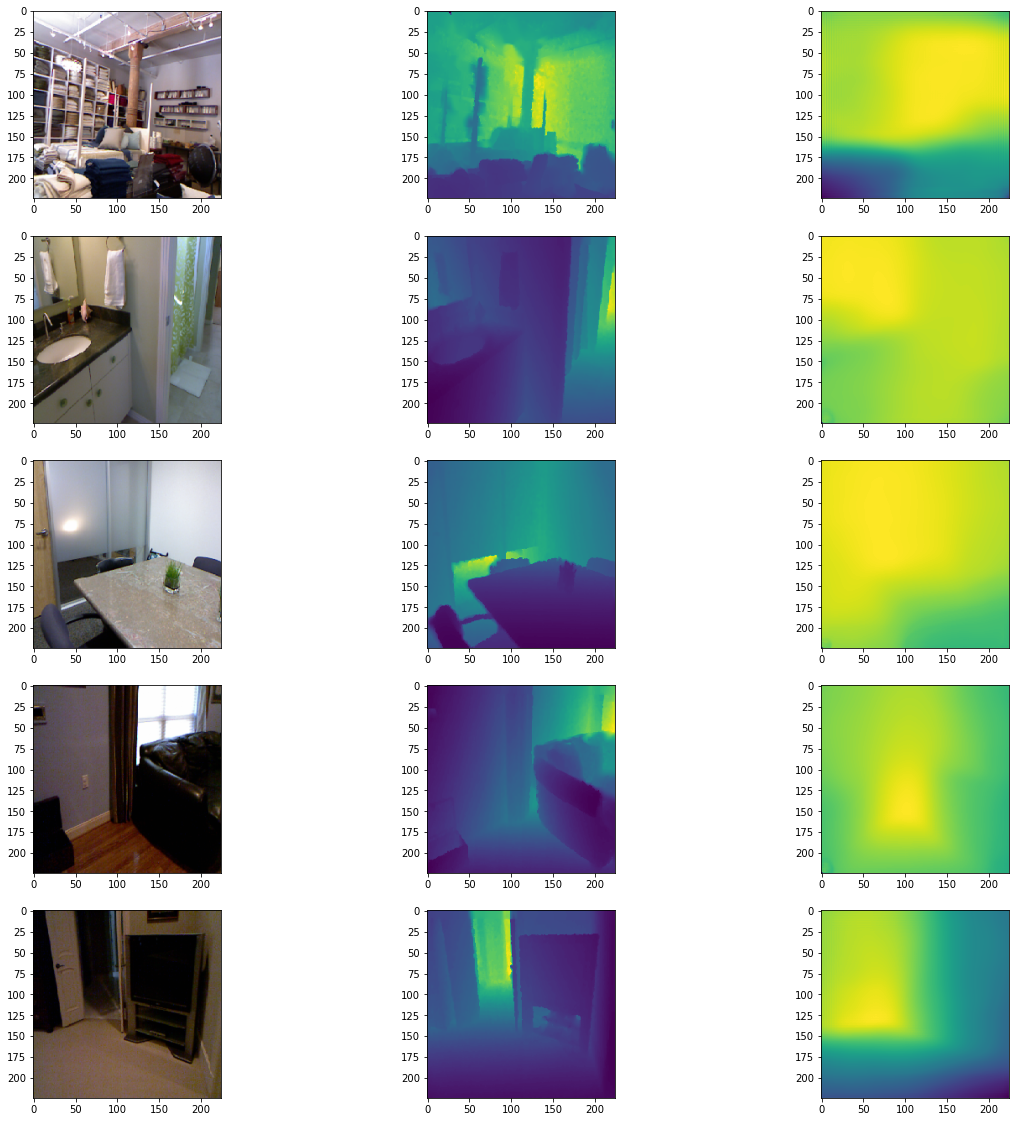

In [15]:
show_results(images, depths, predicted_depths)

In [47]:
def prediction(truth_depths, predicted_depths):
    n = len(truth_depths)
    rmse = 0
    delta1 = 0
    for i in range(n):
        prediction = predicted_depths[i]
        truth = truth_depths[i]
        
        abs_diff = (prediction - truth).abs()
        mse = float((torch.pow(abs_diff, 2)).mean())
        rmse += math.sqrt(mse)
        
        maxRatio = torch.max(prediction / truth, truth / prediction)
        delta1 += float((maxRatio < 1.25).float().mean())
    return {'rmse': rmse, 'delta1': delta1, 'n': n}

In [48]:
prediction(depths, predicted_depths)

{'rmse': 4.328849336788423, 'delta1': 2.429747313261032, 'n': 5}

In [49]:
location = "/home/dlkhagvazhav/data/nyudepthv2/val/"
filenames = getnames(location)
valset = NyuDataset(filenames, train=False)
valloader = DataLoader(valset, batch_size=8, shuffle=True)

In [50]:
general_result = {'rmse': 0, 'delta1': 0, 'n': 0}
for i, (images, depths) in enumerate(valloader):
    predictions_ = model(images)
    result = prediction(depths, predictions_)
    general_result['rmse'] += result['rmse']
    general_result['delta1'] += result['delta1']
    general_result['n'] += result['n']

In [53]:
print('rmse: {}'.format(general_result['rmse']/general_result['n']))
print('delta1: {}'.format(general_result['delta1']/general_result['n']))

rmse: 1.0559716269899986
delta1: 0.4342946471955801
